In [14]:
# --- imports ---
import ast
import numpy as np
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt


In [15]:
df = pd.read_csv('/Users/arturoreza/Documents/isac_2025/events_360_data/events_df_Liga_MX_2022_2023.csv')

/var/folders/mm/5rp42wfn61b3g1r33d3fnfvc0000gn/T/ipykernel_5229/1979095185.py:1: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,50,51,52,53,56,65,66,67,69,70,71,72,73,74,75,76,77,79,80,81,82,84,87,89,90,91,92,93,94,99,106,107,108,109,110,111,112,116,117,118,119,120,121,122,125,126,128,129,130,132,134,139) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/arturoreza/Documents/isac_2025/events_360_data/events_df_Liga_MX_2022_2023.csv')


In [23]:
# 1) Parse location into real lists (if it's stored as strings)
df["location"] = df["location"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [24]:
# Parse pass_end_location if it exists
if 'pass_end_location' in df.columns:
    df["pass_end_location"] = df["pass_end_location"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x != 'nan' else None
    )

In [25]:
# 2) Ensure chronological order within each match/period
sort_cols = [c for c in ["match_id", "index", "timestamp", "period"] if c in df.columns]
if sort_cols:
    df = df.sort_values(sort_cols).reset_index(drop=True)

In [26]:
# 3) Build mask for corners by play pattern + pass type
mask = (
    (df["play_pattern"] == "From Corner") &
    (df["pass_type"] == "Corner")
)

In [27]:
# 4) Get corner data with intended landing location (pass_end_location)
cols_keep = [c for c in ["match_id", "period", "minute", "second", "team", "player", "location", "pass_end_location"] if c in df.columns]
df_corners = df.loc[mask, cols_keep].copy()

In [28]:
print(f"Total corner kicks found: {len(df_corners)}")
print(f"Corners with pass_end_location data: {df_corners['pass_end_location'].notna().sum()}")

Total corner kicks found: 3355
Corners with pass_end_location data: 3355


In [30]:
dfp = df_corners.copy()

In [32]:
# Parse locations
def to_xy(v):
    if isinstance(v, (list, tuple)) and len(v) == 2: return v
    if isinstance(v, str):
        try:
            out = ast.literal_eval(v)
            if isinstance(out, (list, tuple)) and len(out) == 2:
                return out
        except Exception:
            pass
    return [None, None]

dfp["corner_xy"] = dfp["location"].apply(to_xy)
dfp["land_xy"]   = dfp["pass_end_location"].apply(to_xy)  # Use intended landing location

dfp[["cx","cy"]] = pd.DataFrame(dfp["corner_xy"].tolist(), index=dfp.index)
dfp[["x","y"]]   = pd.DataFrame(dfp["land_xy"].tolist(), index=dfp.index)

# Remove rows with missing data
dfp = dfp.dropna(subset=["cx","cy","x","y"])

# --- Normalize so every corner is toward the right-hand goal (x near 120) ---
dfp["x_norm"] = dfp["x"].copy()
dfp["y_norm"] = dfp["y"].copy()

# if the CORNER was taken on the left side (cx < 60), mirror both corner + landing
mask_left = dfp["cx"] < 60
dfp.loc[mask_left, "x_norm"] = 120 - dfp.loc[mask_left, "x_norm"]
dfp.loc[mask_left, "y_norm"] = 80 - dfp.loc[mask_left, "y_norm"]

# --- Define short corners based on intended delivery ---
SHORT_CORNER_DISTANCE = 25  # Adjust this threshold as needed
dfp["distance"] = dfp.apply(
    lambda row: ((row["x"] - row["cx"])**2 + (row["y"] - row["cy"])**2)**0.5,
    axis=1
)
dfp["is_short"] = dfp["distance"] < SHORT_CORNER_DISTANCE

In [33]:
# Distribution by side
left_corners = len(dfp[dfp["cx"] < 60])
right_corners = len(dfp[dfp["cx"] >= 60])
print(f"Corners from left side: {left_corners}")
print(f"Corners from right side: {right_corners}")

Corners from left side: 0
Corners from right side: 3355


In [39]:
# Short corner analysis
short_corners = len(dfp[dfp["is_short"]])
long_corners = len(dfp[~dfp["is_short"]])
print(f"Short corners: {short_corners} ({short_corners/len(dfp)*100:.1f}%)")
print(f"Long corners: {long_corners} ({long_corners/len(dfp)*100:.1f}%)")

# Short corners by side
left_short = len(dfp[(dfp["cx"] < 60) & dfp["is_short"]])
right_short = len(dfp[(dfp["cx"] >= 60) & dfp["is_short"]])

print(f"\nShort corners from left side: {left_short} ({left_short/left_corners*100:.1f}% of left corners)")
print(f"Short corners from right side: {right_short} ({right_short/right_corners*100:.1f}% of right corners)")

Short corners: 491 (14.6%)
Long corners: 2864 (85.4%)


ZeroDivisionError: division by zero

In [37]:
# Average distances
print(f"\nAverage corner distance: {dfp['distance'].mean():.2f} units")
print(f"Left side average distance: {dfp[dfp['cx'] < 60]['distance'].mean():.2f} units")
print(f"Right side average distance: {dfp[dfp['cx'] >= 60]['distance'].mean():.2f} units")


Average corner distance: 36.25 units
Left side average distance: nan units
Right side average distance: 36.25 units


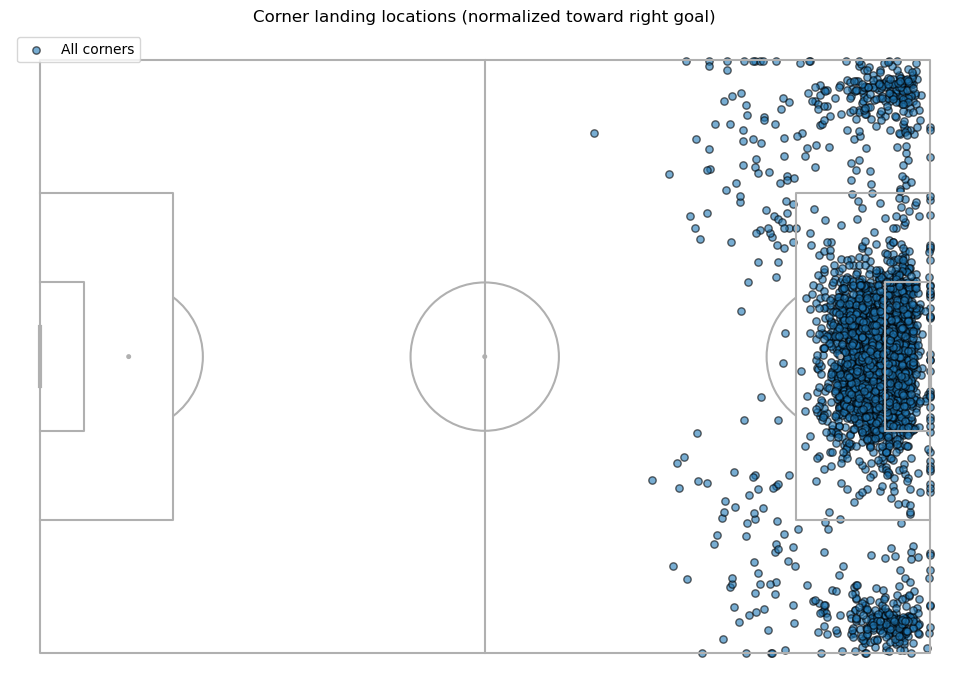

In [36]:
# --- Plot ---
pitch = Pitch(pitch_type="statsbomb", line_zorder=2, linewidth=1.5)
fig, ax = pitch.draw(figsize=(10,7))

# Plot all corner landing locations
ax.scatter(dfp["x_norm"], dfp["y_norm"], s=28, alpha=0.6, edgecolor="k", label="All corners")

ax.set_title("Corner landing locations (normalized toward right goal)")
ax.legend()
plt.show()